#### CSCA 5642 Introduction to Deep Learning
# CNN Cancer Detection Kaggle Mini-Project

***

### Project Summary
The objective of this competition is **to detect the presence of metastatic cancer in small image patches taken from larger digital pathology scans**. This is a critical problem in medical diagnostics, as early detection of cancer can significantly improve treatment outcomes. 

This project is an assignment of Week 3 in the class that I'm taking, Introduction to Deep Learning.

### Data Source
The data is gathered from [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/data).

The dataset includes training and test sets. The training data consists of **220,025 images, each sized 96x96 pixels, accompanied by corresponding labels: '0' for no cancer and '1' for cancer**. These images are extracted from larger whole slide images and are stored in TIFF format. The test data comprises a set of images without labels, which will be used to evaluate the model's performance. The images are small patches of tissue, with each patch representing a different region of a slide, making the dataset diverse in terms of tissue structures and staining variations.

### Evaluation
The primary evaluation metric for this competition is the Area Under the ROC Curve (AUC), which measures the model's ability to distinguish between cancerous and non-cancerous images.

***
# EDA (Exploratory Data Analysis)

Let's do EDA for finding unexpected discoveries and clean it for accurate analysis.

In [38]:
!pip install tensorflow

In [40]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 36.8 MB/s eta 0:00:0000:0100:01


In [42]:
!pip install scikit-learn

  Using cached scikit_learn-1.5.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (12 kB)
Using cached scikit_learn-1.5.1-cp311-cp311-macosx_12_0_arm64.whl (11.0 MB)


In [114]:
# Import Libraries
import os
import shutil
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(101)
tf.random.set_seed(101)

# Constants
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
TRAIN_PATH = './data/train'
TEST_PATH = './data/test'
BASE_DIR = './data/base_dir'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')

# Load data without unhelpful images
df_data = pd.read_csv('./data/train_labels.csv')
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

Let's start by displaying the first few rows of the dataset to understand its structure. We'll also check for any missing values and provide basic statistics.

In [115]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [116]:
df_data.isnull().sum()
df_data['label'].value_counts()

label
0    130907
1     89116
Name: count, dtype: int64

We observe that the **dataset consists of 220,025 labeled images with no missing values**. Around 130K numbers of non-cancerous (0) and 89K numbers of cancerous (1) images, which means the data is not completely balanced as Kaggle said. We are going to consider this imbalance when building a model.

To clarification, let's plot the class distribution to understand more.

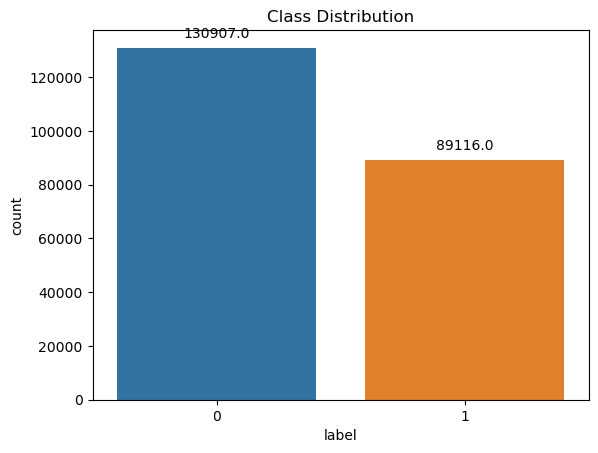

In [117]:
# Plot class distribution
sns.countplot(x='label', data=df_data)
plt.title('Class Distribution')

# Add labels on top of the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

For further investigating of the data, **we will visualize a few sample images from each class**.

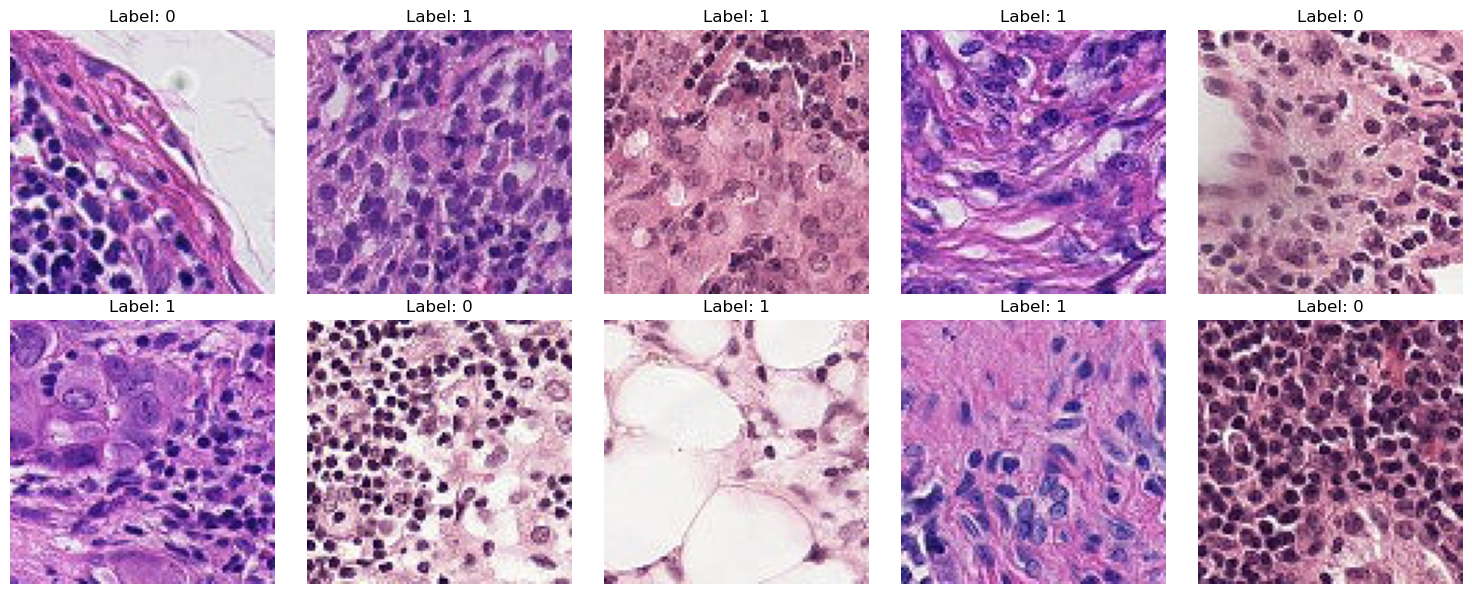

In [118]:
def show_images(image_ids, labels, ncols=5):
    nrows = len(image_ids) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))
    for ax, img_id in zip(axes.flatten(), image_ids):
        img_path = f'./data/train/{img_id}.tif'
        image = Image.open(img_path)
        ax.imshow(image)
        ax.set_title(f'Label: {labels.loc[labels.id == img_id, "label"].values[0]}')
        ax.axis('off')
    plt.tight_layout()

# Display sample images
sample_ids = df_data.sample(10)['id'].values
show_images(sample_ids, df_data)


# Plan of analysis
Based on our exploratory data analysis we did so far, the plan for analysis includes:

- Split data into training and validation sets 
- Data Augmentation: Apply transformations such as rotations, flips, and zooms to augment the dataset.
- Model Building: Construct a Convolutional Neural Network (CNN) to classify the images.
- Model Training: Train the model using the augmented dataset.
- Evaluation: Evaluate the model performance using metrics such as accuracy and the Area Under the ROC Curve (AUC).

By following this plan, we aim to build a robust model capable of accurately detecting metastatic cancer in histopathologic images.

# Model building

Firstly, we **split the data into training and validation sets** using stratified sampling to maintain the label distribution. We then create the necessary directory structure for stroing training and validation images. Besides, we'll set up data generators for training, validation, and testing data using `ImageDataGenerator` to preprocess the images.

In [119]:
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=df_data['label'])

In [120]:
for path in [BASE_DIR, TRAIN_DIR, VAL_DIR]:
    os.makedirs(path, exist_ok=True)
    os.makedirs(os.path.join(path, 'a_no_tumor_tissue'), exist_ok=True)
    os.makedirs(os.path.join(path, 'b_has_tumor_tissue'), exist_ok=True)

In [121]:
# Function for transfer images from the original training set to the new training and validation directories.
def transfer_images(image_list, target_dir, source_dir):
    for _, row in image_list.iterrows():
        fname = row['id'] + '.tif'
        label = 'a_no_tumor_tissue' if row['label'] == 0 else 'b_has_tumor_tissue'
        src = os.path.join(source_dir, fname)
        dst = os.path.join(target_dir, label, fname)
        shutil.copyfile(src, dst)

transfer_images(df_train, TRAIN_DIR, TRAIN_PATH)
transfer_images(df_val, VAL_DIR, TRAIN_PATH)

In [122]:
print(len(os.listdir('./data/base_dir/train/a_no_tumor_tissue')))
print(len(os.listdir('./data/base_dir/train/b_has_tumor_tissue')))

117816
80204


In [123]:
print(len(os.listdir('./data/base_dir/val/a_no_tumor_tissue')))
print(len(os.listdir('./data/base_dir/val/b_has_tumor_tissue')))

13091
8912


In [124]:
datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_directory(TRAIN_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=10, class_mode='categorical')
val_gen = datagen.flow_from_directory(VAL_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=10, class_mode='categorical')
test_gen = datagen.flow_from_directory(VAL_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=1, class_mode='categorical', shuffle=False)

Found 198020 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


We're going to define the **CNN architecture using Keras**.

In [125]:
# Define the Convolutional Neural Network (CNN) architecture using Keras.

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

/Users/younyeongchoi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [126]:
# Compile the CNN model with the Adam optimizer, binary cross-entropy loss, and accuracy as a metric.
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [127]:
checkpoint = ModelCheckpoint("model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr]

We're then going to train the CNN model using the training and validation data generators.

In [128]:
# Train the model
history = model.fit(train_gen, steps_per_epoch=train_gen.samples // train_gen.batch_size, validation_data=val_gen,
                    validation_steps=val_gen.samples // val_gen.batch_size, epochs=1, verbose=1, callbacks=callbacks_list)

/Users/younyeongchoi/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19802/19802 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7894 - loss: 0.4547
Epoch 1: val_accuracy improved from -inf to 0.84150, saving model to model.keras
19802/19802 ━━━━━━━━━━━━━━━━━━━━ 7459s 377ms/step - accuracy: 0.7894 - loss: 0.4547 - val_accuracy: 0.8415 - val_loss: 0.3439 - learning_rate: 1.0000e-04


Then, let's evaluate the trained model on the test data generator to obtain loss and accuracy.

In [129]:
# Evaluate the model
val_loss, val_acc = model.evaluate(test_gen, steps=len(test_gen))
print(f'val_loss: {val_loss}, val_acc: {val_acc}')

22003/22003 ━━━━━━━━━━━━━━━━━━━━ 128s 6ms/step - accuracy: 0.8157 - loss: 0.3774
val_loss: 0.3439628481864929, val_acc: 0.8414761424064636


Based on the model we trained above, let's plot the loss and accuracy curves.

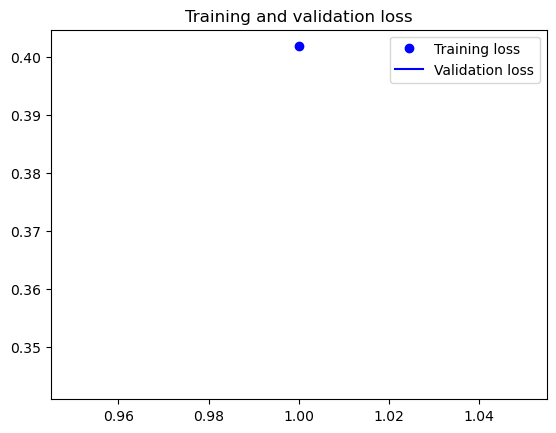

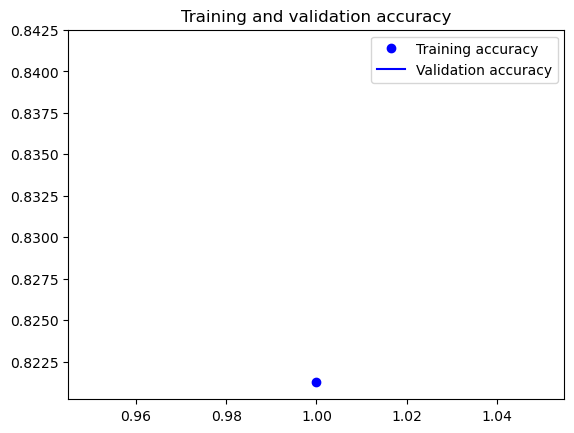

In [130]:
# Plot training history
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure()
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

plot_training_history(history)

In [131]:
# Predictions
predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
y_true = test_gen.classes
y_pred = df_preds['has_tumor_tissue']

22003/22003 ━━━━━━━━━━━━━━━━━━━━ 164s 7ms/step


In [132]:
# ROC AUC Score
print('ROC AUC Score:', roc_auc_score(y_true, y_pred))

ROC AUC Score: 0.9337813903696086


In [133]:
# Confusion matrix
cm = confusion_matrix(y_true, predictions.argmax(axis=1))
print('Confusion Matrix:', cm)

Confusion Matrix: [[10563  2528]
 [  960  7952]]


# Submission
For successful submission of the file, prepare the csv file with id and label, delete the base_dir.

In [134]:
# Prepare submission file
def extract_id(x):
    return x.split('/')[1].split('.')[0]
df_preds['file_names'] = test_gen.filenames
df_preds['id'] = df_preds['file_names'].apply(extract_id)
submission = df_preds[['id', 'has_tumor_tissue']].rename(columns={'has_tumor_tissue': 'label'}).set_index('id')
submission.to_csv('patch_preds.csv')

In [135]:
# Cleanup
# shutil.rmtree(BASE_DIR)